## FAVAR Model - Python Implementation Demo

This notebook demonstrates the Factor-Augmented Vector Autoregressive (FAVAR) model implementation in Python

## Background

The FAVAR model, introduced by Bernanke et al. (2005), combines factor models with Vector Autoregressive (VAR) models to analyze the effects of monetary policy using a large dataset of macroeconomic variables.

## Author
HuangZhifan & WuYixing

## References
https://github.com/lyx66/Factor-augmented-vector-autoregressive-FAVAR-WINRATS-code-package-

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
# plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import FAVAR modules
from favar_model import FAVARModel
from data_processing import DataProcessor, DataValidator, create_synthetic_data
from variance_decomposition import FAVARVarianceDecomposition

d:\anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Data Loading and Preprocessing

In [2]:
# Initialize data processor
processor = DataProcessor()
validator = DataValidator()

# Define data file paths
data_dir = Path("../")
xdata_file = data_dir / "xdata.XLSX"
ydata_file = data_dir / "ydata.XLSX"

# Check if data files exist
if xdata_file.exists() and ydata_file.exists():
    print("Loading real data...")
    
    # Prepare FAVAR data
    data_dict = processor.prepare_favar_data(str(xdata_file), str(ydata_file))
    
    xdata = data_dict['xdata']
    ydata = data_dict['ydata']
    
    print(f"Loaded real data: {xdata.shape[1]} variables, {xdata.shape[0]} observations")
    
else:
    print("Real data files not found. Creating synthetic data for demonstration...")
    
    # Create synthetic data
    xdata, ydata = create_synthetic_data(n_obs=300, n_vars=119)
    
    print(f"Created synthetic data: {xdata.shape[1]} variables, {xdata.shape[0]} observations")

# Display basic info
print(f"\nTime period: {xdata.index[0]} to {xdata.index[-1]}")
print(f"Observable factors: {list(ydata.columns)}")

Loading real data...
Loading data files...
Loaded xdata: 119 variables, 511 observations
Loaded ydata: 1 variables, 511 observations
Common time period: 511 observations
From 1959:01 to 2001:07
Handling missing data...
Loaded real data: 119 variables, 511 observations

Time period: 1959:01 to 2001:07
Observable factors: ['FYFF']


In [3]:
# Validate data quality
xdata_validation = validator.validate_data_quality(xdata, "X-data (Large Dataset)")
ydata_validation = validator.validate_data_quality(ydata, "Y-data (Observable Factors)")

validator.print_validation_report()


DATA VALIDATION REPORT

Dataset: X-data (Large Dataset)
  Shape: (511, 119)
  Missing values: 0 (0.00%)
  Infinite values: 0
  Constant columns: 0
  Time gaps: 0
  Potential outliers: 646
  ✓ Good data quality

Dataset: Y-data (Observable Factors)
  Shape: (511, 1)
  Missing values: 0 (0.00%)
  Infinite values: 0
  Constant columns: 0
  Time gaps: 0
  Potential outliers: 8
  ✓ Good data quality


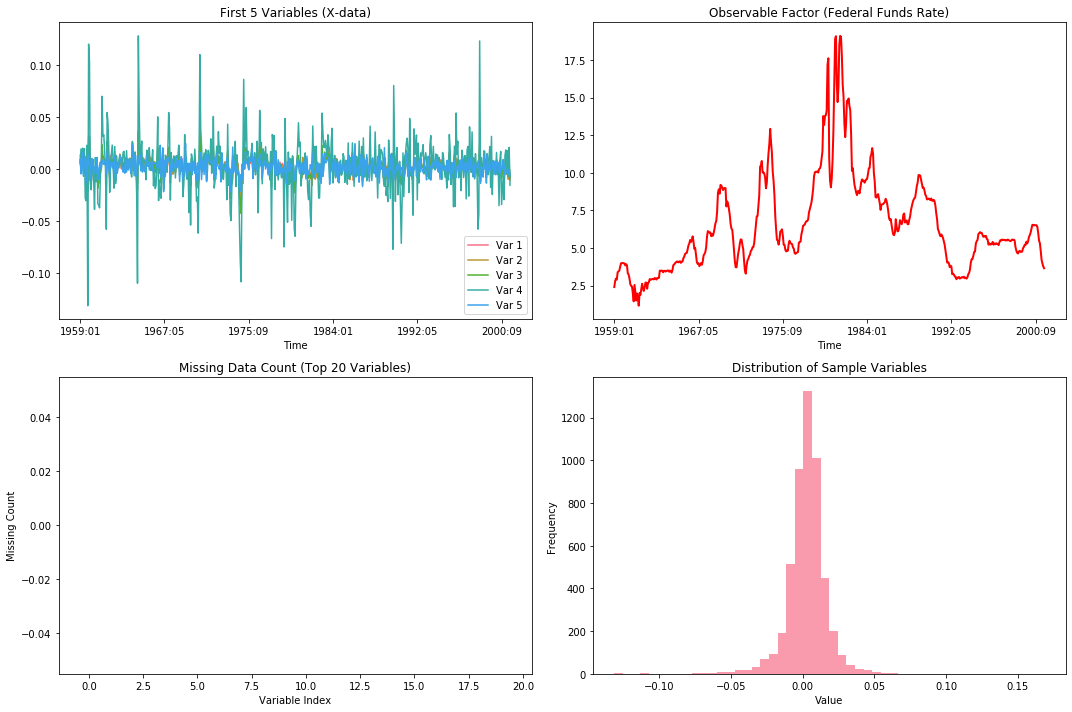

In [4]:
plot_interval = 100

# Visualize data overview
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: First few variables from xdata
axes[0, 0].plot(xdata.iloc[:, :5])
axes[0, 0].set_title('First 5 Variables (X-data)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].legend([f'Var {i+1}' for i in range(5)])
ticks = np.arange(0, len(xdata.index), plot_interval)
axes[0, 0].set_xticks(ticks)

# Plot 2: Observable factor (FFR)
axes[0, 1].plot(ydata.iloc[:, 0], 'r-', linewidth=2)
axes[0, 1].set_title('Observable Factor (Federal Funds Rate)')
axes[0, 1].set_xlabel('Time')
ticks = np.arange(0, len(ydata.index), plot_interval)
axes[0, 1].set_xticks(ticks)

# Plot 3: Missing data heatmap
missing_data = xdata.isnull().sum().sort_values(ascending=False)[:20]
axes[1, 0].bar(range(len(missing_data)), missing_data.values)
axes[1, 0].set_title('Missing Data Count (Top 20 Variables)')
axes[1, 0].set_xlabel('Variable Index')
axes[1, 0].set_ylabel('Missing Count')

# Plot 4: Data distribution
sample_data = xdata.iloc[:, :10].values.flatten()
axes[1, 1].hist(sample_data[~np.isnan(sample_data)], bins=50, alpha=0.7)
axes[1, 1].set_title('Distribution of Sample Variables')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2. FAVAR Model Estimation

In [5]:
# Initialize FAVAR model with parameters matching the original RATS code
favar = FAVARModel(
    n_factors=3,      # Number of latent factors
    n_lags=7,         # VAR lags
    n_steps=48,       # IRF horizon
    n_draws=500      # Bootstrap draws (reduced for demo)
)

print("FAVAR Model initialized with parameters:")
print(f"  Factors: {favar.n_factors}")
print(f"  Lags: {favar.n_lags}")
print(f"  IRF Steps: {favar.n_steps}")
print(f"  Bootstrap Draws: {favar.n_draws}")

FAVAR Model initialized with parameters:
  Factors: 3
  Lags: 7
  IRF Steps: 48
  Bootstrap Draws: 500


In [6]:
# Step 1: Load data into model
favar.xdata = xdata
favar.ydata = ydata

# Step 2: Preprocess data
favar.preprocess_data()

print("Data preprocessing completed")
print(f"Standardized data shape: {favar.xdata_standardized.shape}")

Preprocessing data...
              IPP       IPF       IPC      IPCD      IPCN       IPE       IPI  \
1959:01  1.394381  0.716574  0.527500  0.073015  1.013511  0.756749  1.719712   
1959:02  0.437210  0.265966 -0.242637  0.602236 -0.908430  0.546986  1.201718   
1959:03  1.517133  1.441028  1.405078  0.116657  1.955128  1.786595  1.418287   
1959:04  0.731071  0.832849  0.257938  0.628940 -0.268800  2.285882  0.340671   
1959:05  0.568802  0.537415 -0.743213  0.156282 -1.216490  1.575666  0.103588   
...           ...       ...       ...       ...       ...       ...       ...   
2001:03 -1.023737 -0.959215 -0.535353 -0.296517 -0.578875 -1.304744 -0.829609   
2001:04 -0.483339 -0.587591 -0.158183  0.541154 -0.742334 -0.910752 -0.033089   
2001:05 -1.511185 -1.543767 -0.744324 -0.388333 -0.829293 -2.152018 -0.886724   
2001:06 -0.340630 -0.110892  0.204765  0.655289 -0.272355 -0.598725 -0.823321   
2001:07 -1.538539 -1.627163 -1.070703 -0.702687 -1.060309 -1.654318 -0.757987   

     

Extracting 3 factors...


Factors extracted. Explained variance ratio: [0.18697999 0.12466303 0.09449666]
Factor extraction completed
Explained variance ratio: [0.18697999 0.12466303 0.09449666]
Cumulative explained variance: [0.18697999 0.31164303 0.40613968]


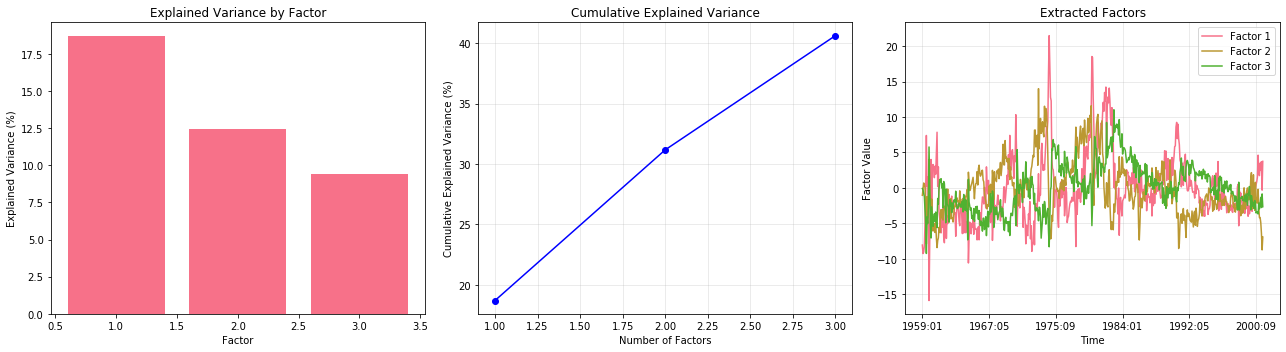

In [7]:
# Step 3: Extract factors using PCA
favar.extract_factors()

print("Factor extraction completed")
print(f"Explained variance ratio: {favar.pca_all.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(favar.pca_all.explained_variance_ratio_)}")

# Visualize factor extraction results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot explained variance
explained_var = favar.pca_all.explained_variance_ratio_
axes[0].bar(range(1, len(explained_var) + 1), explained_var * 100)
axes[0].set_title('Explained Variance by Factor')
axes[0].set_xlabel('Factor')
axes[0].set_ylabel('Explained Variance (%)')

# Plot cumulative explained variance
cumulative_var = np.cumsum(explained_var)
axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var * 100, 'bo-')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Number of Factors')
axes[1].set_ylabel('Cumulative Explained Variance (%)')
axes[1].grid(True, alpha=0.3)

# Plot extracted factors
for i in range(favar.n_factors):
    axes[2].plot(favar.factors.index, favar.factors.iloc[:, i], label=f'Factor {i+1}')
axes[2].set_title('Extracted Factors')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Factor Value')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
ticks = np.arange(0, len(favar.factors.index), plot_interval)
axes[2].set_xticks(ticks)

plt.tight_layout()
plt.show()

Rotating factors...
Factor rotation completed
Factor rotation completed


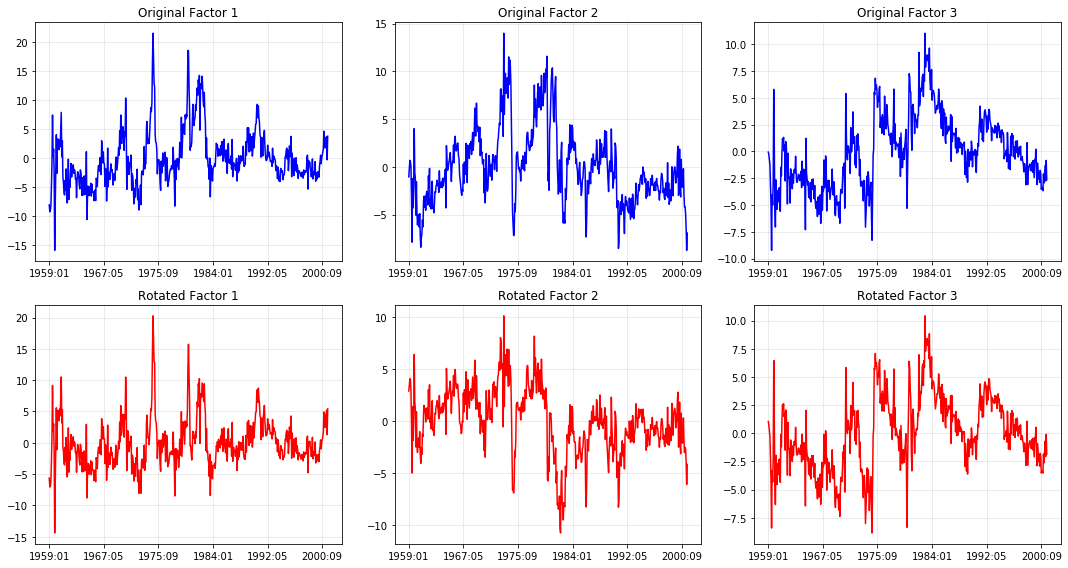

In [8]:
# Step 4: Rotate factors
favar.rotate_factors()

print("Factor rotation completed")

# Compare original and rotated factors
fig, axes = plt.subplots(2, favar.n_factors, figsize=(5*favar.n_factors, 8))

for i in range(favar.n_factors):
    # Original factors
    axes[0, i].plot(favar.factors.index, favar.factors.iloc[:, i], 'b-')
    axes[0, i].set_title(f'Original Factor {i+1}')
    axes[0, i].grid(True, alpha=0.3)
    ticks = np.arange(0, len(favar.factors.index), plot_interval)
    axes[0, i].set_xticks(ticks)
    
    # Rotated factors
    axes[1, i].plot(favar.rotated_factors.index, favar.rotated_factors.iloc[:, i], 'r-')
    axes[1, i].set_title(f'Rotated Factor {i+1}')
    axes[1, i].grid(True, alpha=0.3)
    ticks = np.arange(0, len(favar.rotated_factors.index), plot_interval)
    axes[1, i].set_xticks(ticks)

plt.tight_layout()
plt.show()

In [9]:
# Step 5: Estimate VAR model
favar.estimate_var()

print("VAR estimation completed")
print(f"Selected lags: {favar.var_results.k_ar}")
print(f"AIC: {favar.var_results.aic:.2f}")
print(f"Variables in VAR: {favar.var_results.names}")

# Display VAR summary
print("\nVAR Model Summary:")
print(favar.var_results.summary())

Estimating VAR model with 7 lags...
VAR model estimated. Selected lags: 7
AIC: -2.16467698110457
VAR estimation completed
Selected lags: 7
AIC: -2.16
Variables in VAR: ['PC_new_1', 'PC_new_2', 'PC_new_3', 'FYFF']

VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Jul, 2025
Time:                     22:36:15
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -1.19281
Nobs:                     504.000    HQIC:                  -1.78345
Log likelihood:          -2199.08    FPE:                   0.114845
AIC:                     -2.16468    Det(Omega_mle):       0.0918178
--------------------------------------------------------------------
Results for equation PC_new_1
                 coefficient       std. error           t-stat            prob
---------------------------------------------------------------------

## 3. Impulse Response Analysis

In [10]:
# Compute impulse response functions
print("Computing impulse response functions...")
favar.compute_impulse_responses()

print("IRF computation completed")
print(f"Available IRF results: {list(favar.irf_results.keys())}")

Computing impulse response functions...
Computing impulse response functions...
Shock variable: FYFF
Performing bootstrap with 500 draws...


Bootstrap draws: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]


Bootstrap completed
Impulse response functions computed
IRF computation completed
Available IRF results: ['PC_new_1', 'PC_new_2', 'PC_new_3', 'FYFF']


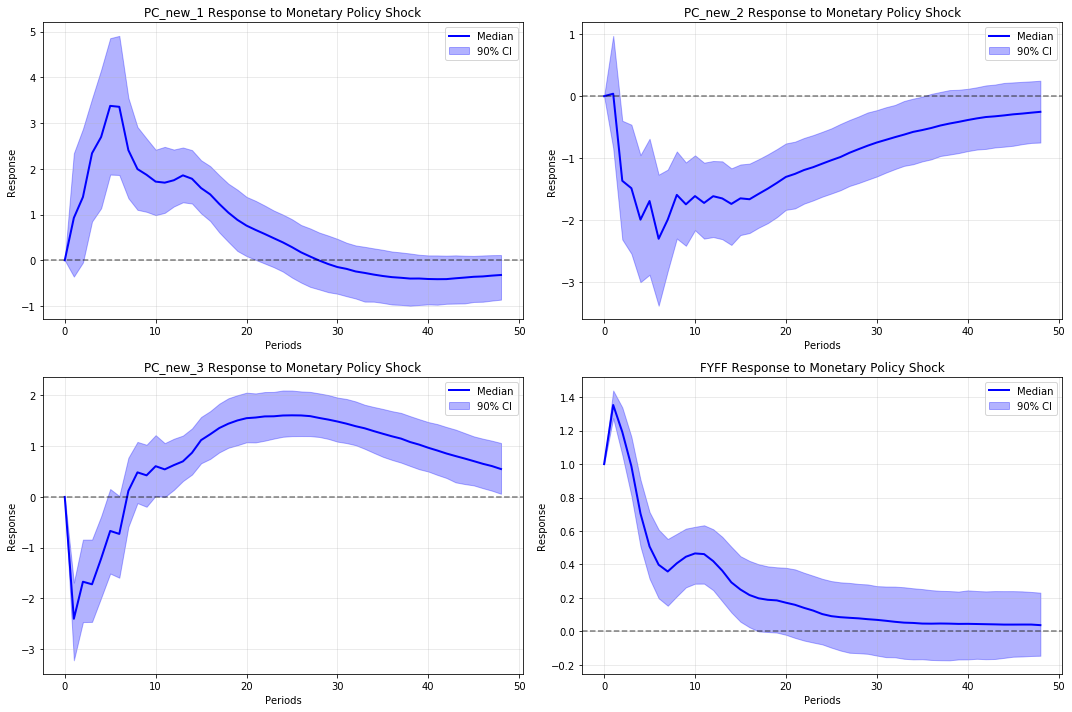

In [11]:
# Plot factor-level impulse responses
n_factors = len([k for k in favar.irf_results.keys() if 'PC_new' in k])
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

periods = range(favar.n_steps+1)

for i, var in enumerate(favar.irf_results.keys()):
    if i >= 4:  # Limit to 4 plots
        break
        
    data = favar.irf_results[var]
    
    # Plot median response
    axes[i].plot(periods, data['median'], 'b-', linewidth=2, label='Median')
    
    # Plot confidence bands
    axes[i].fill_between(periods, data['lower_5'], data['upper_95'], 
                        alpha=0.3, color='blue', label='90% CI')
    
    # Add zero line
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    axes[i].set_title(f'{var} Response to Monetary Policy Shock')
    axes[i].set_xlabel('Periods')
    axes[i].set_ylabel('Response')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [12]:
# Transform factor-level IRFs to variable-level
print("Transforming IRFs to variable level...")
favar.transform_to_variables()

print(f"Variable-level IRFs computed for {len(favar.variable_irfs)} variables")
print(f"Available variables: {list(favar.variable_irfs.keys())[:10]}...")  # Show first 10

Transforming IRFs to variable level...
Transforming IRFs to original variables...
Computing factor loadings for rotated factors...
Computed loadings for 19 variables
IRFs computed for 19 variables
Variable transformation codes applied:
  IP: code 5 (log_diff), R² = 0.746
  IPXMCA: code 1 (levels), R² = 0.749
  LHEM: code 5 (log_diff), R² = 0.251
  LHUR: code 1 (levels), R² = 0.820
  GMCQ: code 5 (log_diff), R² = 0.110
  GMCDQ: code 5 (log_diff), R² = 0.063
  GMCNQ: code 5 (log_diff), R² = 0.063
  HSFR: code 4 (log), R² = 0.404
  MOCMQ: code 5 (log_diff), R² = 0.243
  FSDXP: code 1 (levels), R² = 0.555
  EXRJAN: code 5 (log_diff), R² = 0.025
  FYGM3: code 1 (levels), R² = 0.975
  FYGT5: code 1 (levels), R² = 0.933
  FM2: code 5 (log_diff), R² = 0.053
  FMFBA: code 5 (log_diff), R² = 0.105
  PMCP: code 1 (levels), R² = 0.640
  PUNEW: code 5 (log_diff), R² = 0.863
  LEHM: code 5 (log_diff), R² = 0.212
  HHSNTN: code 1 (levels), R² = 0.711
Variable-level IRFs computed for 19 variables
Avai

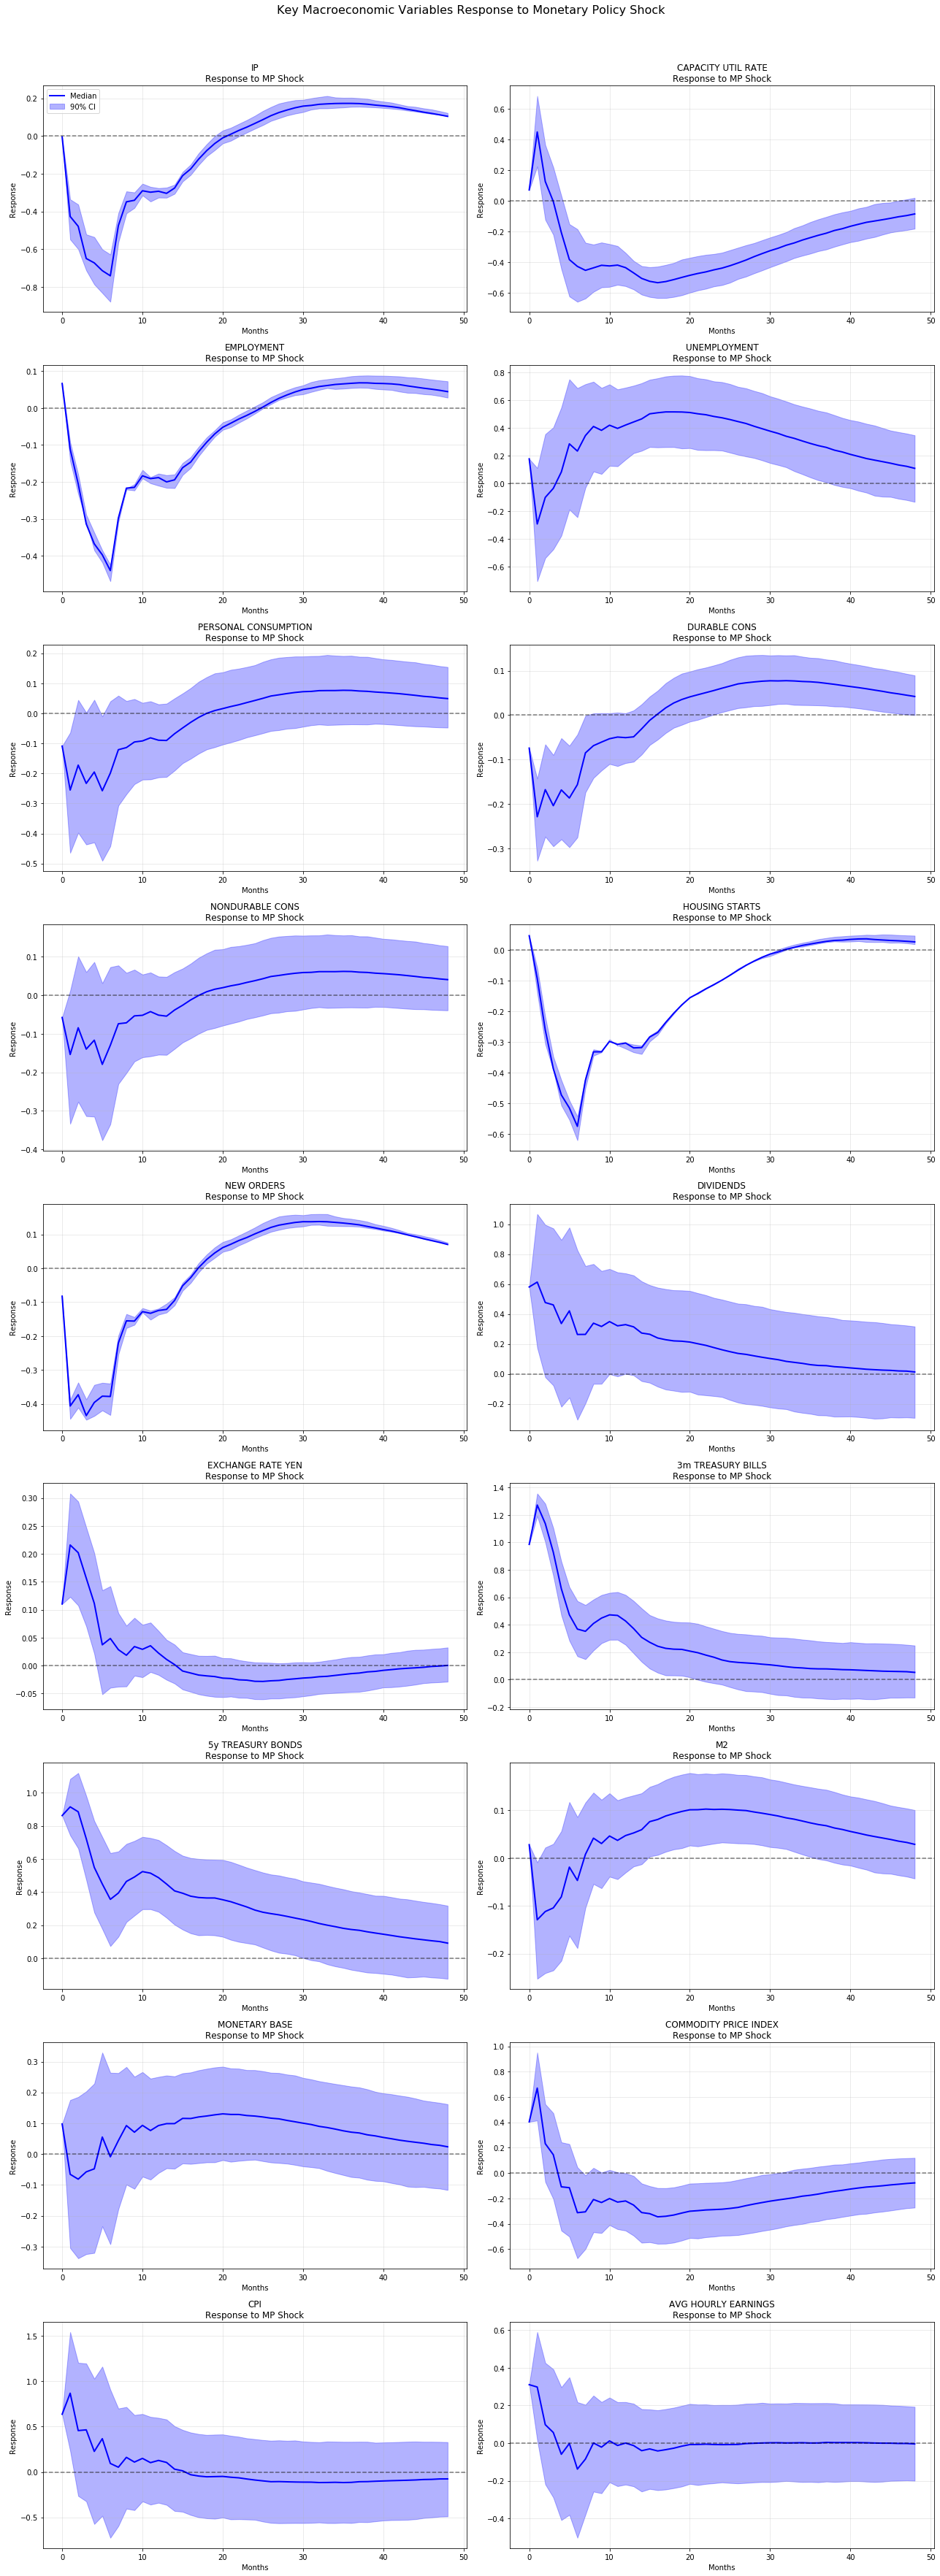

In [13]:
key_dict = {
            'ip': (5, "IP"),
            'punew': (5, "CPI"), 
            'fygm3': (1, "3m TREASURY BILLS"),
            'fygt5': (1, "5y TREASURY BONDS"),
            'fmfba': (5, "MONETARY BASE"),
            'fm2': (5, "M2"),
            'exrjan': (5, "EXCHANGE RATE YEN"),
            'pmcp': (1, "COMMODITY PRICE INDEX"),
            'ipxmca': (1, "CAPACITY UTIL RATE"),
            'gmcq': (5, "PERSONAL CONSUMPTION"),
            'gmcdq': (5, "DURABLE CONS"),
            'gmcnq': (5, "NONDURABLE CONS"),
            'lhur': (1, "UNEMPLOYMENT"),
            'lhem': (5, "EMPLOYMENT"),
            'lehm': (5, "AVG HOURLY EARNINGS"),
            'hsfr': (4, "HOUSING STARTS"),
            'mocmq': (5, "NEW ORDERS"),
            'fsdxp': (1, "DIVIDENDS"),
            'hhsntn': (1, "CONSUMER EXPECTATIONS")
        }

# Plot key variable responses
key_vars_to_plot = list(favar.variable_irfs.keys())[:18]  # First 6 variables

fig, axes = plt.subplots(9, 2, figsize=(18, 48))
axes = axes.flatten()

for i, var in enumerate(key_vars_to_plot):
    data = favar.variable_irfs[var]
    
    # Plot median response
    axes[i].plot(periods, data['median'], 'b-', linewidth=2, label='Median')
    
    # Plot confidence bands
    axes[i].fill_between(periods, data['lower_5'], data['upper_95'], 
                        alpha=0.3, color='blue', label='90% CI')
    
    # Add zero line
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    axes[i].set_title(f'{key_dict[var.lower()][1]}\nResponse to MP Shock')
    axes[i].set_xlabel('Months')
    axes[i].set_ylabel('Response')
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].legend()

plt.suptitle('Key Macroeconomic Variables Response to Monetary Policy Shock', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 4. Variance Decomposition Analysis

In [14]:
# Compute variance decomposition
print("Computing variance decomposition...")
vd_analyzer = FAVARVarianceDecomposition(favar, use_generalized=True)
factor_vd, variable_vd = vd_analyzer.compute_full_variance_decomposition(horizon=40)

print("Variance decomposition completed")

Computing variance decomposition...
Using coefs property: 7 lag matrices of shape (4, 4)
Computing variance decomposition using statsmodels FEVD...
Computing generalized variance decomposition...
Variance decomposition completed


Variance Decomposition Results (Sample):
    Horizon Variable     Shock  Contribution
0         1       IP  PC_new_1     59.098050
1         1       IP  PC_new_2      7.327385
2         1       IP  PC_new_3     33.574566
3         1       IP      FYFF      0.000000
4         1    PUNEW  PC_new_1     16.526081
5         1    PUNEW  PC_new_2     83.020133
6         1    PUNEW  PC_new_3      0.453786
7         1    PUNEW      FYFF      0.000000
8         1    FYGM3  PC_new_1     31.320738
9         1    FYGM3  PC_new_2     47.377246
10        1    FYGM3  PC_new_3     21.302016
11        1    FYGM3      FYFF      0.000000
12        1    FYGT5  PC_new_1     25.415707
13        1    FYGT5  PC_new_2     21.242370
14        1    FYGT5  PC_new_3     53.341923
15        1    FYGT5      FYFF      0.000000
16        1    FMFBA  PC_new_1      3.681639
17        1    FMFBA  PC_new_2      6.166133
18        1    FMFBA  PC_new_3     90.152228
19        1    FMFBA      FYFF      0.000000


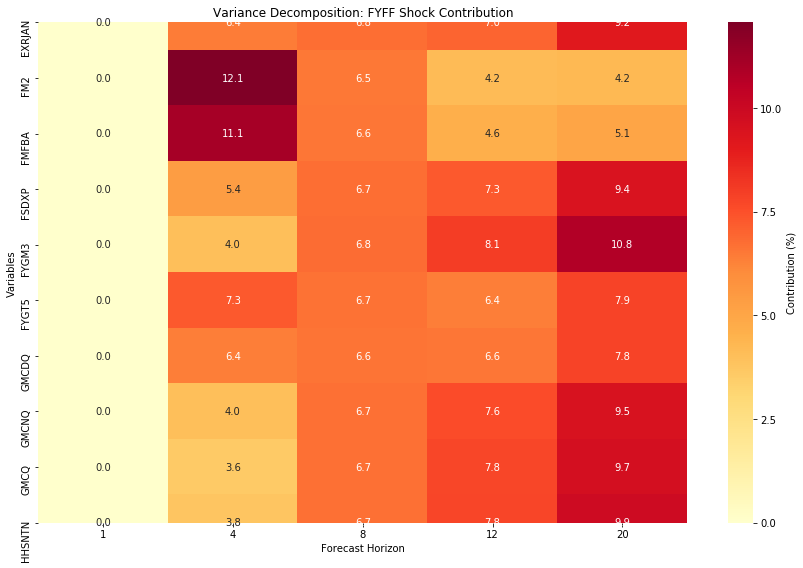

In [15]:
# Format and display variance decomposition results
vd_df = vd_analyzer.format_variable_results(variable_vd, horizons=[1, 4, 8, 12, 20])

print("Variance Decomposition Results (Sample):")
print(vd_df.head(20))

# Create pivot table for visualization
if len(vd_df) > 0:
    # Focus on monetary policy shock contribution
    mp_shock_col = [col for col in favar.var_results.names if 'fyff' in col.lower() or col == favar.var_results.names[-1]][0]
    
    mp_contribution = vd_df[vd_df['Shock'] == mp_shock_col]
    
    if len(mp_contribution) > 0:
        pivot_table = mp_contribution.pivot(index='Variable', columns='Horizon', values='Contribution')
        
        # Plot heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table.iloc[:10], annot=True, fmt='.1f', cmap='YlOrRd',
                   cbar_kws={'label': 'Contribution (%)'})
        plt.title(f'Variance Decomposition: {mp_shock_col} Shock Contribution')
        plt.xlabel('Forecast Horizon')
        plt.ylabel('Variables')
        plt.tight_layout()
        plt.show()

## 5. Model Comparison and Robustness Analysis

In [16]:
# Compare models with different numbers of factors
print("Running robustness analysis with different factor numbers...")

factor_scenarios = [2, 3, 5]
comparison_results = {}

for n_factors in factor_scenarios:
    print(f"\nAnalyzing model with {n_factors} factors...")
    
    # Create model with different factor number
    favar_compare = FAVARModel(
        n_factors=n_factors,
        n_lags=7,
        n_steps=24,  # Reduced for speed
        n_draws=500   # Reduced for speed
    )
    
    try:
        # Load data
        favar_compare.xdata = xdata
        favar_compare.ydata = ydata
        
        # Run analysis
        favar_compare.preprocess_data()
        favar_compare.extract_factors()
        favar_compare.rotate_factors()
        favar_compare.estimate_var()
        favar_compare.compute_impulse_responses()
        favar_compare.transform_to_variables()
        
        comparison_results[n_factors] = favar_compare
        
        print(f"  Model completed. AIC: {favar_compare.var_results.aic:.2f}")
        print(f"  Explained variance: {favar_compare.pca_all.explained_variance_ratio_.sum():.3f}")
        
    except Exception as e:
        print(f"  Error in {n_factors}-factor model: {e}")

Running robustness analysis with different factor numbers...

Analyzing model with 2 factors...
Preprocessing data...
              IPP       IPF       IPC      IPCD      IPCN       IPE       IPI  \
1959:01  1.394381  0.716574  0.527500  0.073015  1.013511  0.756749  1.719712   
1959:02  0.437210  0.265966 -0.242637  0.602236 -0.908430  0.546986  1.201718   
1959:03  1.517133  1.441028  1.405078  0.116657  1.955128  1.786595  1.418287   
1959:04  0.731071  0.832849  0.257938  0.628940 -0.268800  2.285882  0.340671   
1959:05  0.568802  0.537415 -0.743213  0.156282 -1.216490  1.575666  0.103588   
...           ...       ...       ...       ...       ...       ...       ...   
2001:03 -1.023737 -0.959215 -0.535353 -0.296517 -0.578875 -1.304744 -0.829609   
2001:04 -0.483339 -0.587591 -0.158183  0.541154 -0.742334 -0.910752 -0.033089   
2001:05 -1.511185 -1.543767 -0.744324 -0.388333 -0.829293 -2.152018 -0.886724   
2001:06 -0.340630 -0.110892  0.204765  0.655289 -0.272355 -0.598725 -0.8

Bootstrap draws: 100%|██████████| 500/500 [05:50<00:00,  1.43it/s]


Bootstrap completed
Impulse response functions computed
Transforming IRFs to original variables...
Computing factor loadings for rotated factors...
Computed loadings for 19 variables
IRFs computed for 19 variables
Variable transformation codes applied:
  IP: code 5 (log_diff), R² = 0.648
  IPXMCA: code 1 (levels), R² = 0.451
  LHEM: code 5 (log_diff), R² = 0.231
  LHUR: code 1 (levels), R² = 0.236
  GMCQ: code 5 (log_diff), R² = 0.110
  GMCDQ: code 5 (log_diff), R² = 0.056
  GMCNQ: code 5 (log_diff), R² = 0.063
  HSFR: code 4 (log), R² = 0.399
  MOCMQ: code 5 (log_diff), R² = 0.172
  FSDXP: code 1 (levels), R² = 0.430
  EXRJAN: code 5 (log_diff), R² = 0.012
  FYGM3: code 1 (levels), R² = 0.971
  FYGT5: code 1 (levels), R² = 0.832
  FM2: code 5 (log_diff), R² = 0.003
  FMFBA: code 5 (log_diff), R² = 0.013
  PMCP: code 1 (levels), R² = 0.629
  PUNEW: code 5 (log_diff), R² = 0.817
  LEHM: code 5 (log_diff), R² = 0.171
  HHSNTN: code 1 (levels), R² = 0.566
  Model completed. AIC: -1.12
  E

Bootstrap draws: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Bootstrap completed
Impulse response functions computed
Transforming IRFs to original variables...
Computing factor loadings for rotated factors...
Computed loadings for 19 variables
IRFs computed for 19 variables
Variable transformation codes applied:
  IP: code 5 (log_diff), R² = 0.746
  IPXMCA: code 1 (levels), R² = 0.749
  LHEM: code 5 (log_diff), R² = 0.251
  LHUR: code 1 (levels), R² = 0.820
  GMCQ: code 5 (log_diff), R² = 0.110
  GMCDQ: code 5 (log_diff), R² = 0.063
  GMCNQ: code 5 (log_diff), R² = 0.063
  HSFR: code 4 (log), R² = 0.404
  MOCMQ: code 5 (log_diff), R² = 0.243
  FSDXP: code 1 (levels), R² = 0.555
  EXRJAN: code 5 (log_diff), R² = 0.025
  FYGM3: code 1 (levels), R² = 0.975
  FYGT5: code 1 (levels), R² = 0.933
  FM2: code 5 (log_diff), R² = 0.053
  FMFBA: code 5 (log_diff), R² = 0.105
  PMCP: code 1 (levels), R² = 0.640
  PUNEW: code 5 (log_diff), R² = 0.863
  LEHM: code 5 (log_diff), R² = 0.212
  HHSNTN: code 1 (levels), R² = 0.711
  Model completed. AIC: -2.16
  E

Bootstrap draws: 100%|██████████| 500/500 [06:53<00:00,  1.21it/s]


Bootstrap completed
Impulse response functions computed
Transforming IRFs to original variables...
Computing factor loadings for rotated factors...
Computed loadings for 19 variables
IRFs computed for 19 variables
Variable transformation codes applied:
  IP: code 5 (log_diff), R² = 0.908
  IPXMCA: code 1 (levels), R² = 0.758
  LHEM: code 5 (log_diff), R² = 0.266
  LHUR: code 1 (levels), R² = 0.829
  GMCQ: code 5 (log_diff), R² = 0.215
  GMCDQ: code 5 (log_diff), R² = 0.105
  GMCNQ: code 5 (log_diff), R² = 0.096
  HSFR: code 4 (log), R² = 0.785
  MOCMQ: code 5 (log_diff), R² = 0.291
  FSDXP: code 1 (levels), R² = 0.657
  EXRJAN: code 5 (log_diff), R² = 0.097
  FYGM3: code 1 (levels), R² = 0.975
  FYGT5: code 1 (levels), R² = 0.942
  FM2: code 5 (log_diff), R² = 0.486
  FMFBA: code 5 (log_diff), R² = 0.187
  PMCP: code 1 (levels), R² = 0.650
  PUNEW: code 5 (log_diff), R² = 0.864
  LEHM: code 5 (log_diff), R² = 0.297
  HHSNTN: code 1 (levels), R² = 0.712
  Model completed. AIC: -1.39
  E

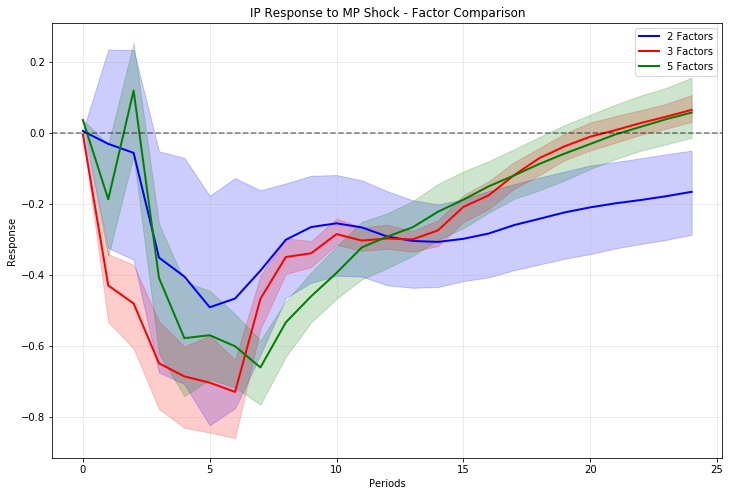


Model Comparison Summary:
   Factors       AIC  Explained Variance  Variables
0        2 -1.119029            0.311643         19
1        3 -2.164677            0.406140         19
2        5 -1.388935            0.491866         19


In [19]:
# Plot comparison of impulse responses
if len(comparison_results) > 1:
    # Select a variable for comparison
    comparison_var = list(comparison_results[list(comparison_results.keys())[0]].variable_irfs.keys())[0]
    
    plt.figure(figsize=(12, 8))
    
    colors = ['blue', 'red', 'green', 'orange']
    
    for i, (n_factors, model) in enumerate(comparison_results.items()):
        if comparison_var in model.variable_irfs:
            data = model.variable_irfs[comparison_var]
            periods = range(model.n_steps+1)
            color = colors[i % len(colors)]
            
            plt.plot(periods, data['median'], color=color, linewidth=2, 
                    label=f'{n_factors} Factors')
            plt.fill_between(periods, data['lower_5'], data['upper_95'], 
                           alpha=0.2, color=color)
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title(f'{comparison_var} Response to MP Shock - Factor Comparison')
    plt.xlabel('Periods')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Create comparison table
    comparison_table = []
    for n_factors, model in comparison_results.items():
        comparison_table.append({
            'Factors': n_factors,
            'AIC': model.var_results.aic,
            'Explained Variance': model.pca_all.explained_variance_ratio_.sum(),
            'Variables': len(model.variable_irfs)
        })
    
    comparison_df = pd.DataFrame(comparison_table)
    print("\nModel Comparison Summary:")
    print(comparison_df)

## 6. Export Results

In [20]:
# Save results to Excel
output_file = "FAVAR_Python_Results.xlsx"
favar.save_results(output_file)

# Save variance decomposition
if len(vd_df) > 0:
    vd_output_file = "FAVAR_Variance_Decomposition.xlsx"
    vd_df.to_excel(vd_output_file, index=False)
    print(f"Variance decomposition saved to: {vd_output_file}")

print(f"All results saved to: {output_file}")

Saving results to FAVAR_Python_Results.xlsx...
Results saved successfully
Variance decomposition saved to: FAVAR_Variance_Decomposition.xlsx
All results saved to: FAVAR_Python_Results.xlsx
